In [412]:
import pandas as pd
import matplotlib as plt
import matplotlib.pyplot as plt
import numpy as np
from sqlite3 import connect

The data covers video games sales from 1971 to current. Some of the data is missing or available so we are taking the final numbers with a grain of salt. 

| Functions | Description | How its used |
| -- | -- | -- |
| check_missing_items | identify missing items in a DataFrame column compared to a list | Runs automatically |
| assign_console_mfg | assigns categories to rows based on predefined console categories| Runs automatically  |
| check_missing_items <br> assign_console_mfg | Used together to checks for missing items, prints a message if any, <br> assigns 'console_mfg' values, and displays the DataFrame with the new column| Runs automatically |
| filter_and_group_by_year | generates DataFrames for years 1971 - 2023 | sales_xxxx  |
| single_graph | This plots a single console and looks at its game sales for a picked time line | single_graph((1990, 2024), 'N64') |
| stacked_graph  | This plots a several consoles and looks at its game sales for a picked time line  | stacked_graph((1980, 2024), 'PS3', 'PS4', 'PS2') |
| graph  |  This plots a several consoles and looks at its game sales for a picked time line | graph((1980, 2024), 'PS3', 'PS4', 'PS2') |

# Reading in the data and verifying its working

In [413]:
df = pd.read_csv('vgchartz-2024.csv')
df.head(1)

,img,title,console,genre,publisher,developer,critic_score,total_sales,na_sales,jp_sales,pal_sales,other_sales,release_date,last_update
0,/games/boxart/full_6510540AmericaFrontccc.jpg,Grand Theft Auto V,PS3,Action,Rockstar Games,Rockstar North,9.4,20.32,6.37,0.99,9.85,3.12,2013-09-17,NaN


# cleaning

- Converting release_date col to datetime
- Dropping the img and last_update cols
- Droppin the rows where the 'release_date' column has missing (NaN) values
- Fills cols 'critic_score', 'total_sales', 'na_sales', 'jp_sales', 'pal_sales', 'other_sales' with missing values to 0 

In [414]:
df['release_date'] = pd.to_datetime(df['release_date'])
df.drop(['img', 'last_update'], axis=1, inplace=True)
df = df.dropna(subset=['release_date'])
columns_to_fill_zero = ['critic_score', 'total_sales', 'na_sales', 'jp_sales', 'pal_sales', 'other_sales']
df[columns_to_fill_zero] = df[columns_to_fill_zero].fillna(0)

In [415]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 56965 entries, 0 to 64014
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   title         56965 non-null  object        
 1   console       56965 non-null  object        
 2   genre         56965 non-null  object        
 3   publisher     56965 non-null  object        
 4   developer     56954 non-null  object        
 5   critic_score  56965 non-null  float64       
 6   total_sales   56965 non-null  float64       
 7   na_sales      56965 non-null  float64       
 8   jp_sales      56965 non-null  float64       
 9   pal_sales     56965 non-null  float64       
 10  other_sales   56965 non-null  float64       
 11  release_date  56965 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(6), object(5)
memory usage: 5.6+ MB


# Functions

The code defines a function `check_missing_items` to identify missing items in a DataFrame column compared to a list. 
<br>
Another function, `assign_console_mfg`, assigns categories to rows based on predefined console categories. 
<br>
The code then checks for missing items, prints a message if any, assigns 'console_mfg' values, and displays the DataFrame with the new column.

In [416]:
def check_missing_items(all_items, df_column):
    all_items_lower = [item.lower().strip() for item in all_items]
    unique_values_lower = set(df_column.str.lower().str.strip().unique())
    return set(all_items_lower) - unique_values_lower

def assign_console_mfg(df):
    categories = {
        'nintendo': ['3DS', 'ds', 'Wii', 'WiiU', 'NS', 'GB', 'NES', 'SNES', 'GBC', 'N64'],
        'pc': ['Linux', 'OSX', 'PC', 'Arc', 'All', 'Series'],
        'xbox': ['X360', 'XOne'],
        'sony': ['PS', 'PS2', 'PS3', 'PS4', 'PS5', 'PSP', 'PSV', 'PSN'],
        'mobile': ['iOS', 'And'],
        'sega': ['GG', 'MSD', 'MS', 'GEN', 'SCD'],
        'atari': ['2600', '7800'],
        'commodore': ['amig', 'C64'],
        'other': ['Ouya', 'OR', 'ACPC', 'AST', 'ApII', 'PCE', 'ZXS', 'Lynx', 'NG', 'ZXS']
    }

    all_items = [item for sublist in categories.values() for item in sublist]

    missing_items = check_missing_items(all_items, df['console'])

    if missing_items:
        print(f"Missing items: {missing_items}")
    else:
        print("All items are covered.")

    conditions = [df['console'].isin(items) for items in categories.values()]
    values = list(categories.keys())

    df['console_mfg'] = np.select(conditions, values, default='unknown')


assign_console_mfg(df)

All items are covered.


Defines a function called `filter_and_group_by_year` 
- which takes a DataFrame (df) and a target year as input
 
- It filters the DataFrame to include only rows from the specified year

- Groups the data by 'release_date' and 'console'
 
- calculates the sum of 'total_sales' for each group
 
- Updates the 'release_date' column to show only the year.

- Then, groups the data again by the modified 'release_date' and 'console' columns

- Calculates the sum of 'total_sales' again 

- Returns the resulting DataFrame.

In the second part of the code
- there is a loop that iterates through years from 1971 to 2023
- In each iteration, it dynamically creates a DataFrame with a name like 'sales_1971', 'sales_1972', etc. 
- Then assigns the result of the function for that specific year to the newly created DataFrame variable.

This loop essentially generates DataFrames for years 1971 - 2023, 
<br>
each representing the sales data for a particular year, and assigns
<br>
them unique names using the 'sales_year' format.

In [417]:
def filter_and_group_by_year(df, target_year):
    df['release_date'] = pd.to_datetime(df['release_date'])
    df_filtered = df[df['release_date'].dt.year == target_year]
    result = df_filtered.groupby(['release_date', 'console'])['total_sales'].sum().reset_index()
    result['release_date'] = result['release_date'].dt.year  
    result = result.groupby(['release_date', 'console'])['total_sales'].sum().reset_index()
    return result

for year in range(1971, 2024):
    df_name = f"sales_{year}"
    globals()[df_name] = filter_and_group_by_year(df, year)

# SQL Connection

This sets up the SQL connection to run queries! 

In [418]:
conn = connect(':memory:')

df.to_sql("df", conn)

def sql(a_string):
    return(pd.read_sql(a_string, conn))

Top 20 video games by sales 

In [419]:
sql("""
    SELECT
        title,
        genre,
        publisher,
        developer,
        AVG(critic_score) AS avg_critic_score,
        SUM(total_sales) AS total_sales,
        MIN(release_date) AS release_date
    FROM
        df
    GROUP BY
        title
    ORDER BY
        total_sales DESC
    LIMIT 20 
""")

,title,genre,publisher,developer,avg_critic_score,total_sales,release_date
0,Grand Theft Auto V,Action,Rockstar Games,Rockstar North,3.512500,64.29,2013-09-17 00:00:00
1,Call of Duty: Black Ops,Shooter,Activision,Treyarch,8.287500,30.99,2010-11-09 00:00:00
2,Call of Duty: Modern Warfare 3,Shooter,Activision,Infinity Ward,6.000000,30.71,2011-11-08 00:00:00
3,Call of Duty: Black Ops II,Shooter,Activision,Treyarch,6.700000,29.59,2012-11-13 00:00:00
4,Call of Duty: Ghosts,Shooter,Activision,Infinity Ward,6.714286,28.80,2013-11-05 00:00:00
5,Call of Duty: Black Ops 3,Shooter,Activision,Treyarch,1.620000,26.72,2015-11-06 00:00:00
6,Call of Duty: Modern Warfare 2,Shooter,Activision,Infinity Ward,4.666667,25.02,2009-11-10 00:00:00
7,Minecraft,Misc,Mojang,Mojang AB,3.138462,24.01,2010-05-10 00:00:00
8,Grand Theft Auto IV,Action,Rockstar Games,Rockstar North,5.840000,22.53,2008-04-29 00:00:00
9,Call of Duty: Advanced Warfare,Shooter,Activision,Sledgehammer Games,8.720000,21.78,2014-11-04 00:00:00


Top 20 publishers 

In [420]:
sql("""
    SELECT
        publisher,
        AVG(critic_score) AS avg_critic_score,
        SUM(total_sales) AS total_sales
    FROM
        df
    GROUP BY
        publisher
    ORDER BY
        total_sales DESC
    LIMIT 20
""")

,publisher,avg_critic_score,total_sales
0,Activision,1.652878,722.77
1,Electronic Arts,2.116316,644.13
2,EA Sports,2.121891,485.66
3,Ubisoft,1.615120,462.57
4,THQ,1.503694,320.89
5,Sony Computer Entertainment,1.621501,311.08
6,Rockstar Games,3.310000,239.67
7,Konami,1.014971,210.70
8,Sega,1.056593,206.38
9,Nintendo,2.570508,140.80


Top 20 Developers

In [421]:
sql("""
    SELECT
        developer,
        AVG(critic_score) AS avg_critic_score,
        SUM(total_sales) AS total_sales,
        MIN(release_date) AS release_date
    FROM
        df
    GROUP BY
        developer
    ORDER BY
        total_sales DESC
    LIMIT 20 
""")

,developer,avg_critic_score,total_sales,release_date
0,EA Canada,2.339130,275.56,1992-01-01 00:00:00
1,EA Tiburon,2.875299,178.33,1995-01-01 00:00:00
2,Ubisoft Montreal,2.825461,172.96,2001-10-15 00:00:00
3,Treyarch,3.874737,150.19,1998-02-23 00:00:00
4,Traveller's Tales,2.238647,149.55,1992-01-01 00:00:00
5,Infinity Ward,3.983673,118.97,2003-10-29 00:00:00
6,Rockstar North,4.736364,116.91,1998-03-27 00:00:00
7,Konami,0.701737,109.42,1981-01-01 00:00:00
8,Visual Concepts,2.206422,97.61,1991-10-01 00:00:00
9,Capcom,1.500899,92.95,1984-12-01 00:00:00


Top Genre

In [422]:
sql("""
    SELECT
        genre,
        AVG(critic_score) AS avg_critic_score,
        SUM(total_sales) AS total_sales,
        MIN(release_date) AS release_date
    FROM
        df
    GROUP BY
        Genre
    ORDER BY
        total_sales DESC
    LIMIT 20 
""")

,genre,avg_critic_score,total_sales,release_date
0,Sports,0.937914,1186.77,1977-01-01 00:00:00
1,Action,0.944825,1124.95,1977-01-01 00:00:00
2,Shooter,1.324475,995.47,1977-01-01 00:00:00
3,Misc,0.263793,557.55,1977-01-01 00:00:00
4,Racing,1.171696,523.51,1977-01-01 00:00:00
5,Role-Playing,1.315013,425.88,1979-01-01 00:00:00
6,Platform,1.154443,349.15,1978-01-01 00:00:00
7,Fighting,1.138357,340.39,1980-01-01 00:00:00
8,Adventure,0.540130,325.09,1977-01-01 00:00:00
9,Simulation,0.564616,300.48,1973-10-08 00:00:00


Top 5 video games with the highest total sales within each console group

In [423]:
sql("""
    SELECT
        console,
        title,
        genre,
        publisher,
        developer,
        critic_score,
        total_sales
    FROM (
        SELECT
            console,
            title,
            genre,
            publisher,
            developer,
            critic_score,
            total_sales,
            ROW_NUMBER() OVER (PARTITION BY console ORDER BY total_sales DESC) AS rank
        FROM
            df
    ) ranked
    WHERE
        rank <= 5
""")

,console,title,genre,publisher,developer,critic_score,total_sales
0,2600,Asteroids,Shooter,Atari,Atari,0.0,4.31
1,2600,Demon Attack,Shooter,Imagic,Imagic,0.0,2.13
2,2600,E.T.: The Extra Terrestrial,Action,Atari,Atari,0.0,1.97
3,2600,Ms. Pac-Man,Puzzle,Atari,General Entertainment,0.0,1.65
4,2600,Dig Dug,Puzzle,Atari,Atari,0.0,1.64
...,...,...,...,...,...,...,...
369,iOS,Super Mario Run,Action,Nintendo,Nintendo,0.0,0.00
370,iOS,CounterSpy,Action,Sony Computer Entertainment,Dynamighty,0.0,0.00
371,iOS,PlayStation All-Stars Island,Action,Sony Computer Entertainment,Zoink Games,0.0,0.00
372,iOS,Bentley's Hackpack,Action,Sony Computer Entertainment,Sony Computer Entertainment,0.0,0.00


total sales for each combination of console and year

In [424]:
sql("""
    SELECT
        console,
        strftime('%Y', release_date) AS year,
        SUM(total_sales) AS total_sales
    FROM
        df
    GROUP BY
        console,
        year
    ORDER BY
        year, console
""")

,console,year,total_sales
0,Series,1971,0.0
1,PC,1973,0.0
2,DS,1975,0.0
3,2600,1977,2.5
4,PC,1977,0.0
...,...,...,...
866,PC,2024,0.0
867,PS4,2024,0.0
868,PS5,2024,0.0
869,XOne,2024,0.0


In [425]:
sql("""
    SELECT
        console,
        strftime('%Y', release_date) AS year,
        SUM(total_sales) AS total_sales
    FROM
        df
    WHERE
        strftime('%Y', release_date) = '2016'
    GROUP BY
        console,
        year
    ORDER BY
     year, console;
""")

,console,year,total_sales
0,3DS,2016,10.72
1,All,2016,0.00
2,And,2016,0.00
3,Arc,2016,0.00
4,DC,2016,0.00
5,DS,2016,0.02
6,Linux,2016,0.00
7,OR,2016,0.00
8,OSX,2016,0.00
9,Ouya,2016,0.00


In [426]:
sql("""
    WITH RankedGames AS (
    SELECT
        console,
        title,
        total_sales,
        ROW_NUMBER() OVER (PARTITION BY console ORDER BY total_sales DESC) AS rank
    FROM
        df
    WHERE
        strftime('%Y', release_date) = '1999'
)
SELECT
    console,
    title,
    total_sales
FROM
    RankedGames
WHERE
    rank = 1;
""")

,console,title,total_sales
0,AJ,Protector,0.00
1,All,Asterix & Obelix Take On Caesar,0.00
2,Amig,WipEout 2097,0.00
3,DC,Sonic Adventure,2.42
4,GB,Medarot 2: Kabuto / Kuwagata Version,0.54
5,GBC,Pokémon Pinball,0.00
6,Lynx,Lexis,0.00
7,N64,Namco Museum 64,1.45
8,NG,Bakumatsu Rouman Dai Ni Maku: Gekka no Kenshi ...,0.00
9,OSX,StarCraft,0.00


# graphing

Defines a function called `filter_and_group_by_year` 
- which takes a DataFrame (df) and a target year as input
 
- It filters the DataFrame to include only rows from the specified year

- Groups the data by 'release_date' and 'console'
 
- calculates the sum of 'total_sales' for each group
 
- Updates the 'release_date' column to show only the year.

- Then, groups the data again by the modified 'release_date' and 'console' columns

- Calculates the sum of 'total_sales' again 

- Returns the resulting DataFrame.

In the second part of the code
- there is a loop that iterates through years from 1971 to 2023
- In each iteration, it dynamically creates a DataFrame with a name like 'sales_1971', 'sales_1972', etc. 
- Then assigns the result of the function for that specific year to the newly created DataFrame variable.

This loop essentially generates DataFrames for years 1971 - 2023, 
<br>
each representing the sales data for a particular year, and assigns
<br>
them unique names using the 'sales_year' format.

In [427]:
def filter_and_group_by_year(df, target_year):
    df['release_date'] = pd.to_datetime(df['release_date'])
    df_filtered = df[df['release_date'].dt.year == target_year]
    result = df_filtered.groupby(['release_date', 'console'])['total_sales'].sum().reset_index()
    result['release_date'] = result['release_date'].dt.year  
    result = result.groupby(['release_date', 'console'])['total_sales'].sum().reset_index()
    return result

for year in range(1971, 2024):
    df_name = f"sales_{year}"
    globals()[df_name] = filter_and_group_by_year(df, year)

In [428]:
sales_2019

,release_date,console,total_sales
0,2019,3DS,1.03
1,2019,All,0.00
2,2019,And,0.00
3,2019,Linux,0.00
4,2019,NS,0.27
5,2019,OR,0.00
6,2019,OSX,0.00
7,2019,PC,0.02
8,2019,PS4,1.23
9,2019,PSV,0.00


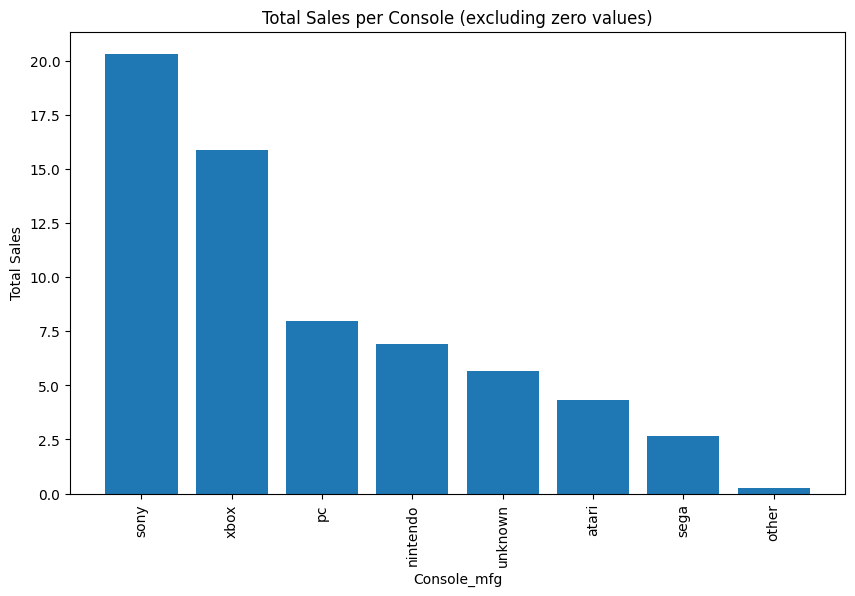

In [429]:
filtered_df = df[df['total_sales'] != 0]

plt.figure(figsize=(10, 6))
plt.bar(filtered_df['console_mfg'], filtered_df['total_sales'])
plt.xlabel('Console_mfg')
plt.ylabel('Total Sales')
plt.title('Total Sales per Console (excluding zero values)')

plt.xticks(rotation='vertical')

plt.show()

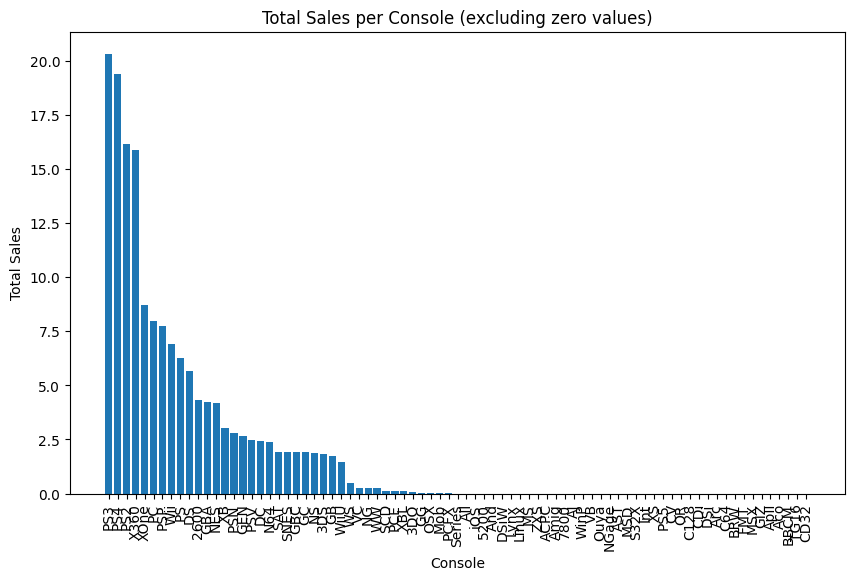

In [430]:
plt.figure(figsize=(10, 6))
plt.bar(df['console'], df['total_sales'])
plt.xlabel('Console')
plt.ylabel('Total Sales')
plt.title('Total Sales per Console (excluding zero values)')

plt.xticks(rotation='vertical')

plt.show()

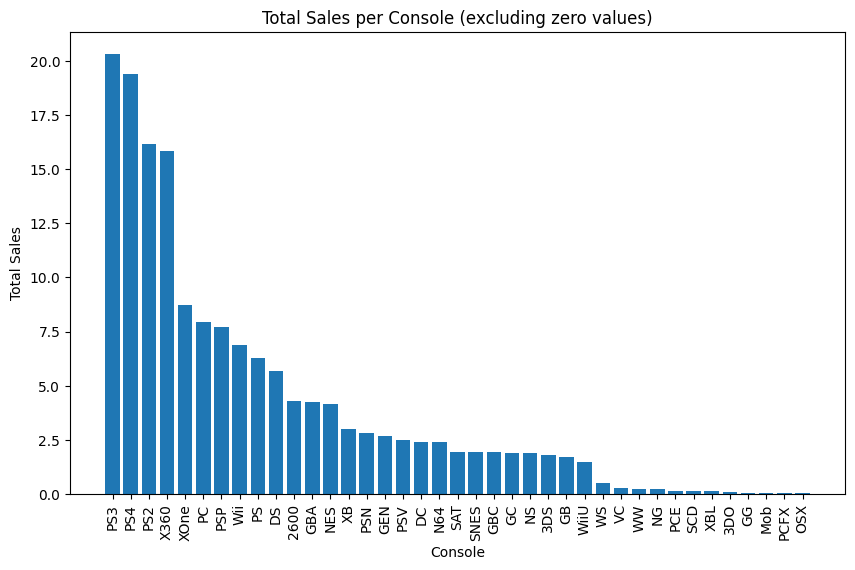

In [431]:
filtered_df = df[df['total_sales'] != 0].sort_values(by='total_sales', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(filtered_df['console'], filtered_df['total_sales'])
plt.xlabel('Console')
plt.ylabel('Total Sales')
plt.title('Total Sales per Console (excluding zero values)')

plt.xticks(rotation='vertical')

plt.show()

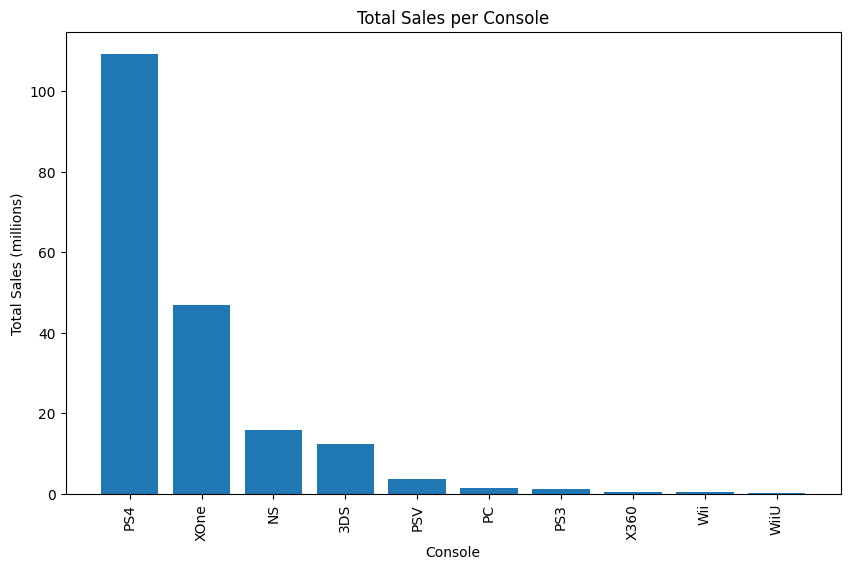

In [432]:
filtered_df = sales_2017[sales_2017['total_sales'] != 0].sort_values(by='total_sales', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(filtered_df['console'], filtered_df['total_sales'])
plt.xlabel('Console')
plt.ylabel('Total Sales (millions)')
plt.title('Total Sales per Console')

plt.xticks(rotation='vertical')

plt.show()

# Function plots

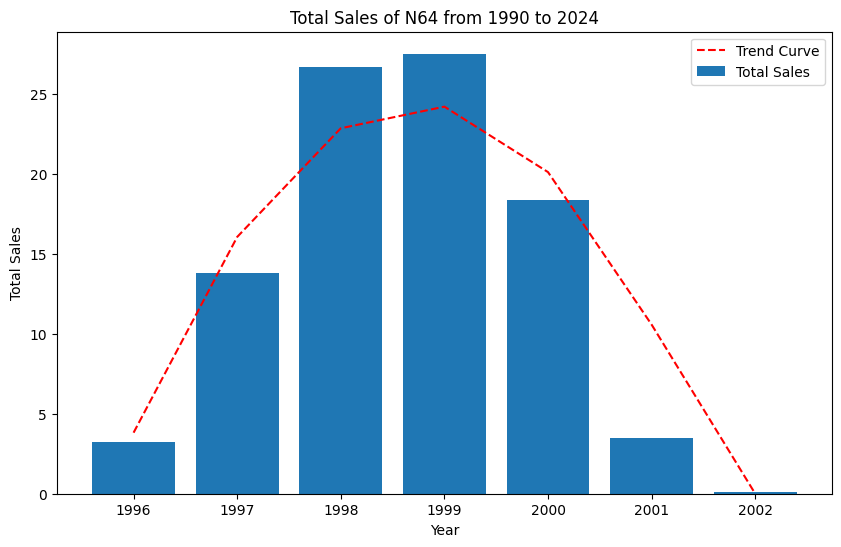

In [433]:
def single_graph(date_range, console):
    
    df['release_date'] = pd.to_datetime(df['release_date'])
    
    
    filtered_df = df[(df['release_date'].dt.year >= date_range[0]) & 
                     (df['release_date'].dt.year <= date_range[1]) & 
                     (df['console'] == console)]

    
    sales_by_year = filtered_df.groupby(filtered_df['release_date'].dt.year)['total_sales'].sum().reset_index()

    
    plt.figure(figsize=(10, 6))
    
    
    plt.bar(sales_by_year['release_date'], sales_by_year['total_sales'], label='Total Sales')
    
    # Trend curve
    x = sales_by_year['release_date']
    y = sales_by_year['total_sales']
    
    z = np.polyfit(x, y, 2)
    p = np.poly1d(z)

    # Clip values below 0
    trend_line = np.maximum(p(x), 0)  
    
    plt.plot(x, trend_line, 'r--', label='Trend Curve')
    
    plt.xlabel('Year')
    plt.ylabel('Total Sales')
    plt.title(f'Total Sales of {console} from {date_range[0]} to {date_range[1]}')
    
    plt.legend()
    
    plt.show()

# Example usage:
single_graph((1990, 2024), 'N64')

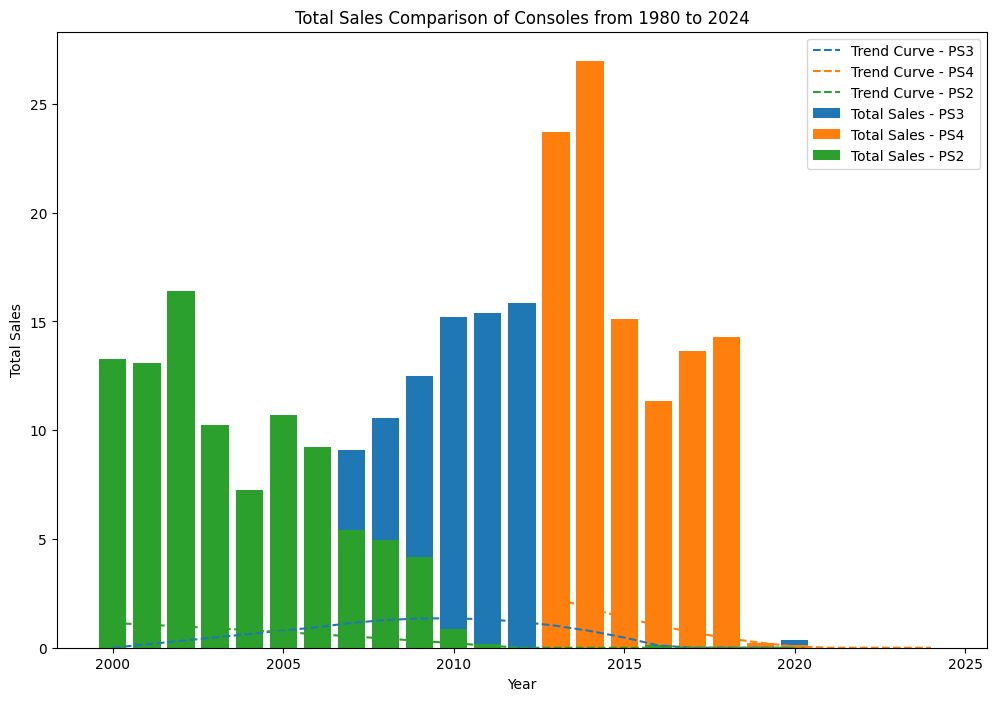

In [434]:
def stacked_graph(date_range, *consoles):
    
    df['release_date'] = pd.to_datetime(df['release_date'])
    
    
    filtered_df = df[(df['release_date'].dt.year >= date_range[0]) & 
                     (df['release_date'].dt.year <= date_range[1]) & 
                     (df['console'].isin(consoles))]

    
    sales_by_year = filtered_df.groupby(['release_date', 'console'])['total_sales'].sum().reset_index()

    
    plt.figure(figsize=(12, 8))
    
    for console in consoles:
        console_data = sales_by_year[sales_by_year['console'] == console]
        x = console_data['release_date'].dt.year  
        y = console_data['total_sales']
        
        # Trend curve
        z = np.polyfit(x, y, 2)
        p = np.poly1d(z)
         # Clip values below 0
        trend_line = np.maximum(p(x), 0) 
        
        # Bar plot
        plt.bar(x, y, label=f'Total Sales - {console}')
        
        # Trend curve plot
        plt.plot(x, trend_line, '--', label=f'Trend Curve - {console}')

    plt.xlabel('Year')
    plt.ylabel('Total Sales')
    plt.title(f'Total Sales Comparison of Consoles from {date_range[0]} to {date_range[1]}')
    
    # Display legend
    plt.legend()
    
    plt.show()

# Example usage:
stacked_graph((1980, 2024), 'PS3', 'PS4', 'PS2')


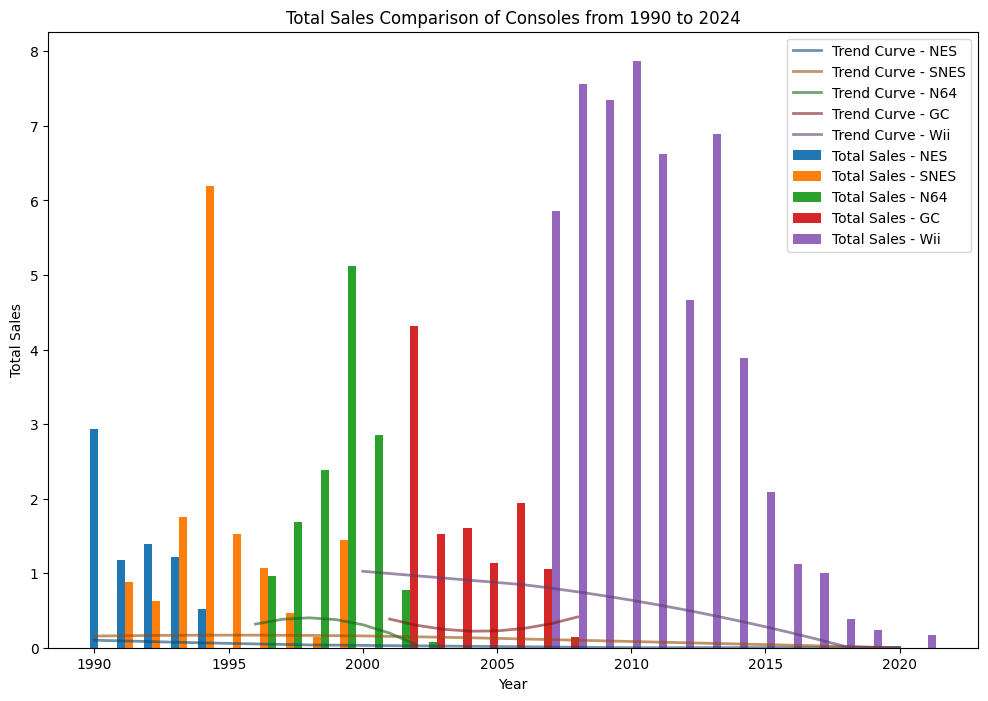

In [435]:
def graph(date_range, *consoles):
   
    df['release_date'] = pd.to_datetime(df['release_date'])
    

    filtered_df = df[(df['release_date'].dt.year >= date_range[0]) & 
                     (df['release_date'].dt.year <= date_range[1]) & 
                     (df['console'].isin(consoles))]

    
    sales_by_year = filtered_df.groupby(['release_date', 'console'])['total_sales'].sum().reset_index()

    
    plt.figure(figsize=(12, 8))
    
    for i, console in enumerate(consoles):
        console_data = sales_by_year[sales_by_year['console'] == console]
        x = console_data['release_date'].dt.year  
        y = console_data['total_sales']
        
        # Trend curve
        z = np.polyfit(x, y, 2)
        p = np.poly1d(z)
        # Clip values below 0
        trend_line = np.maximum(p(x), 0)  
        
        cmap = plt.get_cmap('tab10')
        bar_color = cmap(i)
        darker_bar_color = tuple(c * 0.6 for c in bar_color)
        
        
        plt.bar(x + i * 0.3, y, width=0.3, color=bar_color, label=f'Total Sales - {console}')

        
        plt.plot(x, trend_line, '-', color=darker_bar_color, linewidth=2, label=f'Trend Curve - {console}', zorder=10)

    plt.xlabel('Year')
    plt.ylabel('Total Sales')
    plt.title(f'Total Sales Comparison of Consoles from {date_range[0]} to {date_range[1]}')
    
    
    plt.legend()
    
    plt.show()

# Example usage:
graph((1990, 2024), 'NES', 'SNES', 'N64', 'GC', 'Wii')
